# api notebook

https://ims.gov.il/he/ObservationDataAPI

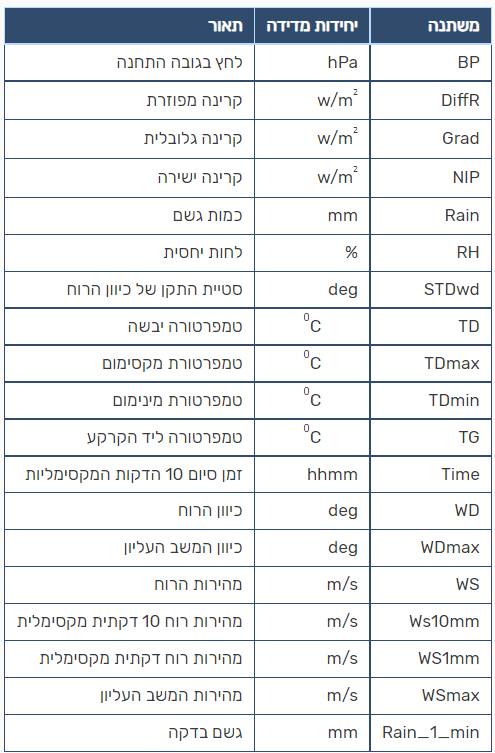

In [24]:
import pandas as pd
import numpy as np

import requests
import json

import selenium
from selenium import webdriver
import time
import os

from random import randint
from time import sleep
import asyncio

### Connection to API ###

#### We declare connection HTTP headers with authorization data we got from the Israel Meteorological Service ####

In [1]:
authorization_headers={ 'Authorization': 'ApiToken f058958a-d8bd-47cc-95d7-7ecf98610e47' }

In [26]:
url_stations_metadata=  "https://api.ims.gov.il/v1/Envista/stations"
stations_metadata = requests.request("GET", url_stations_metadata, headers=authorization_headers) 
stations_metadata_json = json.loads(stations_metadata.text.encode('utf8'))
stations_df=pd.json_normalize(stations_metadata_json)

### Generating DF of stations in areas with chose ###

In [27]:
#unnecessary data
cols_to_remove=['monitors','StationTarget']

for col in cols_to_remove:
    del stations_df[col]
#we chose to focus on central areas and these are the region ids from the Israel Meteorological API 
regions=[6,11,13,14,15]
specific_stations_df= None
for region in regions:
    stations_df_copy=stations_df.copy()
    if specific_stations_df is None:
        specific_stations_df=stations_df_copy[stations_df_copy.regionId == region]
    else:
        specific_stations_df=specific_stations_df.append(stations_df_copy[stations_df_copy.regionId == region])
stations_id_list=np.array(specific_stations_df['stationId'].tolist())
print(stations_id_list)
specific_stations_df.to_csv("specific_stations.csv")

[ 18  26 243  42  43  45  67 263 311 312 314 317 332  54  85 178 212 275
 299 318  58  74  79  82 121 124 208 236 244 245 252 274 283 284 285 291
 336  41  44  46  78 106 107 246 276 310 313 315 343 345]


#### we checked which data returns for each station in the response JSON (using postman) and generating columns for df row accordingly ####

In [28]:
def generate_row_per_dateTime(obj,station):
    row={}
    row['stationId']=station
    date_end_index=obj["datetime"].find('T')
    row['date']=obj["datetime"][:date_end_index]
    for channel in obj['channels']:
        if(channel["valid"]):
            colName=channel["name"]
            colValue=channel["value"]
            row[colName]= colValue
    return json.dumps(row)  

In [29]:
def extract_data_station(month_json,station):
    station_data_df=None
    params=[]
    title=''
    count=0
    colName=''
    colValue=''
    json_row=None
    current_df_row=None
    for obj in month_json['data']:
        count=count+1
        json_row=json.loads(generate_row_per_dateTime(obj,station))
        current_df_row=pd.json_normalize(json_row)
        if station_data_df is None:
            station_data_df=current_df_row
        else:
            station_data_df=station_data_df.append(current_df_row)
        json_row=None
    return station_data_df

### Getting ready to merge ###

#### The next 2 functions responsible to adjust station data df  to the crawling data of traffic in the next notebook (for future merging) ####

In [30]:
def getPartialDataFrameByColumnValue(df,columnName,value):
    return df[df[columnName].str.contains(value)]

In [31]:
def getAverageDataFrameByColumn(df,columnName):
    df_copy=df.copy()
    rows_number=df.shape[0]
    station_identity_df=pd.DataFrame()
    station_metadata_df=pd.DataFrame()
    current_date_df=pd.DataFrame()
    merged_df=None
    date=0
    
    stationId=df_copy['stationId'][0]
    station_identity_df=pd.DataFrame({'stationId':[stationId]})
    station_metadata_df=getPartialDataFrameByColumnValue(df_copy,'date',df_copy['date'].iloc[0])
    station_metadata_df.drop(['stationId'], axis=1, inplace=True)
    station_metadata_df.drop(['date'], axis=1, inplace=True) 
    station_metadata_df=station_metadata_df.mean(axis=0).to_frame().T
    current_date_df=pd.concat([station_identity_df,station_metadata_df],axis=1)

    return current_date_df
    

### Final DF generation ###

#### Now we request for weather data in all stations ####

In [ ]:
years=[2017,2018,2019,2020,2021,2022]
months=['01','02','03','04','05','06','07','08','09','10','11','12']
current_station= None
final_stations_data_after_avg=None
problematic_urls=[]
average_for_month_df=None
for station in stations_id_list:
    for year in years:
        for month in months:
            url='https://api.ims.gov.il/v1/envista/stations/{}/data/monthly/{}/{}'.format(station,year,month)
            print(url)
            try:
                station_metadata = requests.request( "GET",url, headers=authorization_headers,timeout=20)
                sleep(0.03)
                if station_metadata.status_code != 204:
                    station_metadata_json = json.loads(station_metadata.text.encode('utf8','ignore'))
                    current_station=extract_data_station(station_metadata.json(),station)
                    current_station = current_station.reset_index()
                    current_station.drop(['index'], axis=1, inplace=True)
                    average_for_month_df=getAverageDataFrameByColumn(current_station,'date').reset_index()
                    average_for_month_df.drop(['index'], axis=1, inplace=True)
                    average_for_month_df['year']=year
                    average_for_month_df['month']=month
                    if final_stations_data_after_avg is None:
                        final_stations_data_after_avg=average_for_month_df
                    else:
                        final_stations_data_after_avg=final_stations_data_after_avg.append(average_for_month_df)
            except Exception as e:
                print(e)
                problematic_urls.append(url)
            
        
        sleep(0.03)

print('finished')


In [16]:
final_stations_data_after_avg.to_csv('final_stations_data_after_avg.csv')

#### The problematic_urls array is for not missing data if a request fails

In [17]:
print(len(problematic_urls))

0


# crawling - selenium

In this notebook, we will perform a web crawling to complete the DF.

### Imports

In [1]:
!pip install selenium

In [2]:
import pandas as pd
import numpy as np
import time
from PIL import Image
import io
import requests

import os
import selenium
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.action_chains import ActionChains

In [3]:
pip install webdriver-manager

Note: you may need to restart the kernel to use updated packages.


### Install Driver and set chrome options

The Chromeoptions class is a concept in Selenium WebDriver for manipulating various Chrome driver features.
Why do we use it? we can access everything that exists on the page and not just what is currently on the screen.
To extract the data from the table we need to make WebDriverWait visibility_of_element_located ().

In [4]:
options = Options()
options.add_argument("start-maximized")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('excludeSwitches', ['enable-logging'])
options.add_experimental_option('useAutomationExtension', False)
options.add_argument('--disable-blink-features=AutomationControlled')

driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)



====== WebDriver manager ======
Current google-chrome version is 102.0.5005
Get LATEST chromedriver version for 102.0.5005 google-chrome
Trying to download new driver from https://chromedriver.storage.googleapis.com/102.0.5005.61/chromedriver_win32.zip
Driver has been saved in cache [C:\Users\gonip\.wdm\drivers\chromedriver\win32\102.0.5005.61]
C:\Users\gonip\AppData\Local\Temp/ipykernel_19548/3690626548.py:8: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)


### Specify Search URL 

In [5]:
search_url="https://www.cbs.gov.il/he/Statistics/Pages/%D7%9E%D7%97%D7%95%D7%9C%D7%9C%D7%99%D7%9D/%D7%9E%D7%97%D7%95%D7%9C%D7%9C-%D7%A1%D7%A4%D7%99%D7%A8%D7%95%D7%AA-%D7%AA%D7%A0%D7%95%D7%A2%D7%94.aspx" 
driver.get(search_url)

We want the all site to go up before we start moving on him

In [6]:
time.sleep(2)

We tried to find the data on the site and were unsuccessful. After browsing the internet and finding similar problemd we understand that the site is on IFRAME

<div>
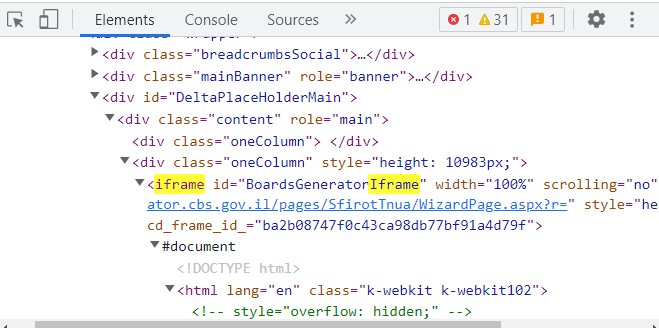
</div>


In [7]:
WebDriverWait(driver, 10).until(EC.frame_to_be_available_and_switch_to_it((By.XPATH,"//iframe[starts-with(@id, 'BoardsGeneratorIframe')]")))

True

We will click on the following buttons to get to the page I want to attract

<div>
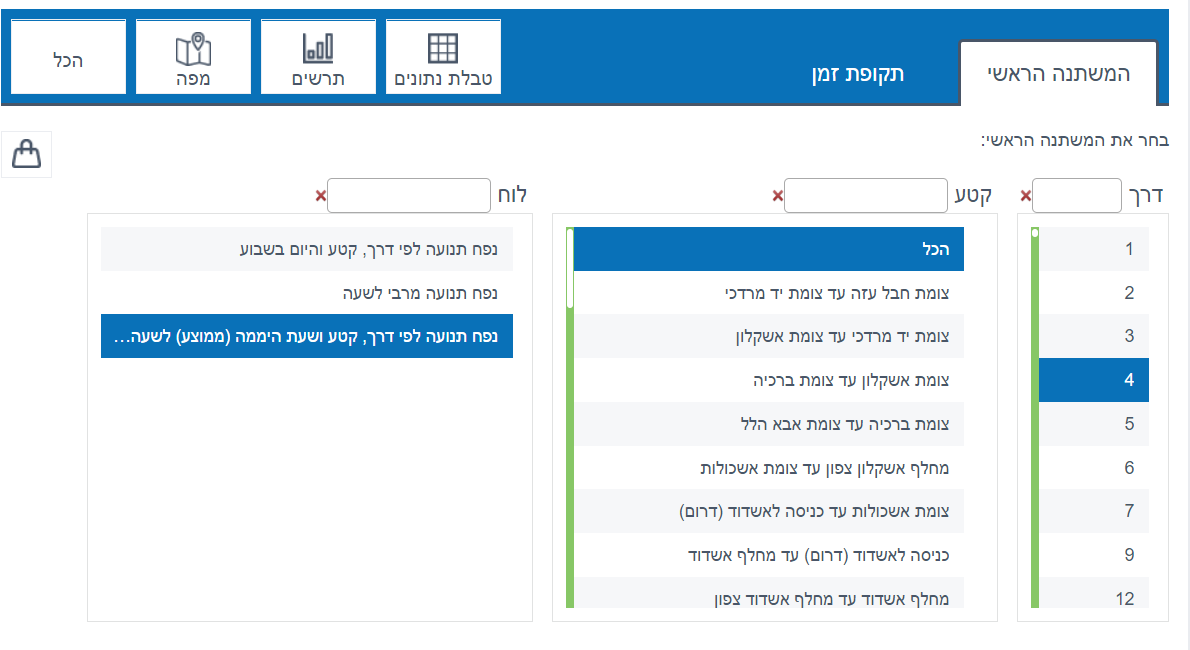
</div>

In [10]:
row_num_4=driver.find_element(By.XPATH, '//*[@id="mainVariableController"]/div[1]/ul/li[1]/div/div/div/div[1]/ul/li[4]/a')
row_num_4.click()
volume=driver.find_element(By.XPATH, '//*[@id="mainVariableController"]/div[1]/ul/li[3]/div/div/div/div/ul/li[3]/a')
volume.click()

<div>
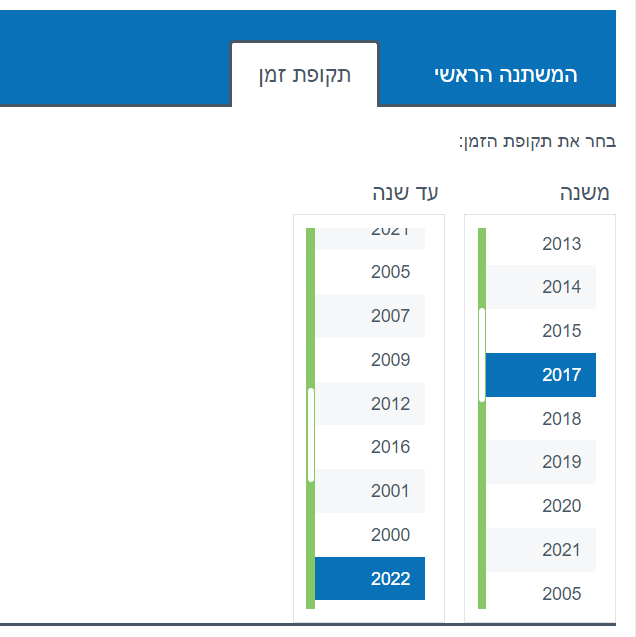
</div>

In [14]:
time_of_data=driver.find_element(By.XPATH, '//*[@id="tabsController"]/div[1]/ul/li[2]')
time_of_data.click()

elemet = driver.find_element(By.XPATH, '//*[@id="periodTimeController"]/div/ul/li[1]/div/div/div/div[1]/ul/li[11]/a')
actions = ActionChains(driver)
actions.move_to_element(elemet).perform()
elemet.click()

select_data=driver.find_element(By.XPATH, '//*[@id="periodTimeController"]/div/div/a')
select_data.click()

now we start to save the data (and the title of the table!) by page numbers (1-4)

#### title

In [15]:
data_titles=driver.find_elements(By.CSS_SELECTOR , "[role='columnheader']")
text_titles = [t.get_attribute('data-title') for t in data_titles]

#### table

Now we need to go from page to page and extract the information from him. We were able to save each page as a list of lists so we did a function that turns the information from a list of lists to DF.

In [16]:
def list_to_df(df, page_data):
    index=1
    for col in df.columns:
        df[col]=page_data[0][index]
        index=index+1
    return df

In [17]:
data_titles=driver.find_elements(By.CSS_SELECTOR , "[role='columnheader']")
text_titles = [t.get_attribute('data-title') for t in data_titles]

page_1_data = WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "table.k-selectable"))).get_attribute("outerHTML")

data_of_page_1= pd.read_html(page_1_data)
df_page_1 = pd.DataFrame(columns =text_titles)

df_page_1=list_to_df(df_page_1,data_of_page_1)

# we do a test how the data see
# df.to_csv("plz.csv"
#          , index=False
#          ,encoding='utf-8-sig')
df_page_1


,דרך,כיוון,שנה,חודש,ממוצע יומי באלפים,0,1,2,3,4,...,14,15,16,17,18,19,20,21,22,23
0,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...
1,דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומת חבל...,0,2017,11,2.8,16,10,4,4,8,...,187,239,189,174,155,110,84,66,52,26
2,דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומת חבל...,0,2018,4,3.2,13,6,5,6,7,...,198,251,204,199,208,129,91,74,58,28
3,דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומת חבל...,0,2019,6,3.5,24,11,6,6,6,...,218,268,228,218,223,143,108,90,77,46
4,דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומת חבל...,0,2020,7,2.8,29,16,9,9,10,...,160,191,173,139,145,141,117,98,68,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,דרך 4 קטע 185 מק''מ 156.2 עד ק''מ 159.5 מצומת ...,0,2022,1,31.2,347,198,144,114,186,...,2109,2167,2095,1906,1659,1481,1193,933,737,573
109,דרך 4 קטע 185 מק''מ 156.2 עד ק''מ 159.5 מצומת ...,1,2022,1,15.2,200,108,75,55,73,...,1045,1083,1113,1008,830,707,564,429,360,309
110,דרך 4 קטע 185 מק''מ 156.2 עד ק''מ 159.5 מצומת ...,2,2022,1,16.0,147,90,69,59,113,...,1064,1084,983,897,829,774,629,503,376,264
111,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...


In [18]:
next_page_to2=driver.find_element(By.XPATH, '//*[@id="grid"]/div[3]/a[3]/span')
next_page_to2.click()

page_2_data = WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "table.k-selectable"))).get_attribute("outerHTML")
df_page_2=pd.DataFrame(columns =text_titles)
data_of_page_2= pd.read_html(page_2_data)
df_page_2=list_to_df(df_page_2,data_of_page_2)
df_page_2

,דרך,כיוון,שנה,חודש,ממוצע יומי באלפים,0,1,2,3,4,...,14,15,16,17,18,19,20,21,22,23
0,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...,דרך: דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מ...
1,דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מצומת ...,1,2017,12,19.0,177,105,75,69,135,...,1188,1366,1269,1166,971,836,618,493,441,357
2,דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מצומת ...,2,2017,12,17.5,164,96,66,59,117,...,1121,1102,1063,995,989,822,637,455,433,273
3,דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מצומת ...,0,2018,4,35.7,378,211,157,131,262,...,2245,2479,2332,2138,1760,1576,1253,1104,972,669
4,דרך 4 קטע 190 מק''מ 159.5 עד ק''מ 161.4 מצומת ...,1,2018,4,17.9,189,106,78,66,131,...,1122,1239,1166,1069,880,788,627,552,486,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,דרך 4 קטע 220 מק''מ 168.7 עד ק''מ 177.4 מצומת ...,2,2021,3,15.4,72,42,34,41,116,...,1014,1017,1064,950,814,665,456,320,241,140
104,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...
105,דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מצומת ...,0,2018,7,15.0,126,74,47,47,103,...,904,1024,1060,996,883,753,597,471,354,257
106,דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מצומת ...,0,2019,11,14.8,86,49,40,44,115,...,976,1068,1053,897,709,606,427,334,265,180


In [19]:
next_page_to3=driver.find_element(By.XPATH, '//*[@id="grid"]/div[3]/a[3]/span')
next_page_to3.click()

page_3_data = WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "table.k-selectable"))).get_attribute("outerHTML")
df_page_3=pd.DataFrame(columns =text_titles)
data_of_page_3= pd.read_html(page_3_data)
df_page_3=list_to_df(df_page_3,data_of_page_3)
df_page_3

,דרך,כיוון,שנה,חודש,ממוצע יומי באלפים,0,1,2,3,4,...,14,15,16,17,18,19,20,21,22,23
0,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...,דרך: דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מ...
1,דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מצומת ...,0,2021,8,15.8,177,103,69,56,73,...,996,1055,1059,1037,949,843,654,506,444,302
2,דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מצומת ...,1,2021,8,8.0,102,63,40,27,35,...,479,474,516,506,504,451,347,241,189,151
3,דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מצומת ...,2,2021,8,7.8,75,40,30,28,38,...,517,581,544,531,445,392,307,265,255,150
4,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...,דרך: דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומת אשכ...,1,2017,1,37.2,651,402,251,202,237,...,2403,2856,2711,2449,2549,2139,1679,1389,1067,891
108,דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומת אשכ...,2,2017,1,32.9,421,251,194,165,232,...,1934,2019,2150,1937,1778,1648,1607,1080,782,612
109,דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומת אשכ...,0,2018,4,68.2,814,514,384,380,673,...,4105,4352,4377,4271,3665,3231,2813,2353,1803,1305
110,דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומת אשכ...,1,2018,4,34.2,465,275,214,190,256,...,2143,2282,2262,2430,2008,1785,1508,1248,967,738


In [20]:
next_page_to4=driver.find_element(By.XPATH, '//*[@id="grid"]/div[3]/a[3]/span')
next_page_to4.click()

page_4_data = WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "table.k-selectable"))).get_attribute("outerHTML")
df_page_4=pd.DataFrame(columns =text_titles)
data_of_page_4= pd.read_html(page_4_data)
df_page_4=list_to_df(df_page_4,data_of_page_4)
df_page_4

,דרך,כיוון,שנה,חודש,ממוצע יומי באלפים,0,1,2,3,4,...,14,15,16,17,18,19,20,21,22,23
0,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...,דרך: דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומ...
1,דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומת אשכ...,0,2019,11,66.4,562,435,369,556,1733,...,4418,4301,4048,3918,3448,2748,2206,1777,1560,1015
2,דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומת אשכ...,1,2019,11,35.0,324,260,194,236,545,...,2483,2436,2292,2328,1924,1518,1250,1017,934,621
3,דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומת אשכ...,2,2019,11,31.3,238,175,175,320,1188,...,1935,1864,1756,1590,1524,1230,956,760,627,394
4,דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומת אשכ...,0,2020,6,64.4,1115,623,446,378,613,...,3955,3912,3865,3848,3676,3128,2763,2349,1879,1458
5,דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומת אשכ...,1,2020,6,32.3,588,316,224,183,279,...,1997,2012,1931,1953,1882,1615,1425,1204,967,778
6,דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומת אשכ...,2,2020,6,32.1,528,306,222,194,334,...,1958,1900,1935,1895,1794,1513,1338,1146,911,679
7,דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומת אשכ...,0,2021,3,86.3,1173,667,479,413,683,...,5385,5397,5407,5212,4831,4396,3933,3222,2576,2100
8,דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומת אשכ...,1,2021,3,42.5,573,328,253,237,458,...,2568,2467,2520,2427,2299,1936,1756,1532,1235,1087
9,דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומת אשכ...,2,2021,3,43.9,600,339,226,175,225,...,2817,2929,2887,2785,2531,2460,2178,1690,1341,1013


now we conect all dfs from all pages to one df

In [21]:
frames = [df_page_1, df_page_2,df_page_3,df_page_4]
df_road_loads = pd.concat(frames)
# result = df.append(df2)
# result

# we do 'index=False,encoding='utf-8-sig'' because we have in the DF text in Hebrew
df_road_loads.to_csv("df_road_loads.csv"
         , index=False
         ,encoding='utf-8-sig')

In [22]:
df_road_loads

,דרך,כיוון,שנה,חודש,ממוצע יומי באלפים,0,1,2,3,4,...,14,15,16,17,18,19,20,21,22,23
0,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...,דרך: דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומ...
1,דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומת חבל...,0,2017,11,2.8,16,10,4,4,8,...,187,239,189,174,155,110,84,66,52,26
2,דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומת חבל...,0,2018,4,3.2,13,6,5,6,7,...,198,251,204,199,208,129,91,74,58,28
3,דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומת חבל...,0,2019,6,3.5,24,11,6,6,6,...,218,268,228,218,223,143,108,90,77,46
4,דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומת חבל...,0,2020,7,2.8,29,16,9,9,10,...,160,191,173,139,145,141,117,98,68,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,דרך 4 קטע 80 מק''מ 105.0 עד ק''מ 106.8 ממחלף ר...,2,2021,8,96.4,2643,1559,911,654,868,...,5735,5996,5892,5928,5956,5676,5241,4738,3414,2787
49,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...,דרך: דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממ...
50,דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממחלף ח...,0,2020,12,124.5,1390,823,538,319,424,...,8151,8067,7786,7333,7212,6725,5245,4339,3313,2073
51,דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממחלף ח...,1,2020,12,56.3,681,415,271,155,186,...,3732,3690,3579,3345,3306,3140,2695,2115,1607,1052


In this notebook we merge two DF

### imports

In [1]:
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

### load DFs

In [2]:
df_road_loads = pd.read_csv('df_road_loads.csv')
df_station=pd.read_csv('final_stations_data_after_avg.csv')
df_station.drop(columns = df_station.columns[0],axis=1,inplace=True)
df_station

,stationId,Rain,WSmax,WDmax,WS,WD,STDwd,TD,RH,TDmax,TDmin,WS1mm,Ws10mm,Time,year,month,Grad,TG,BP
0,42,0.021678,2.996503,151.769231,2.131469,148.629371,12.666434,9.581818,74.972028,9.709790,9.446853,2.638462,2.338462,1174.783217,2017,1,NaN,NaN,NaN
1,42,0.000000,8.979021,97.650350,5.250350,110.839161,17.653147,5.853147,68.720280,5.988811,5.715385,6.993007,5.611189,1173.083916,2017,2,NaN,NaN,NaN
2,42,0.000000,11.289510,126.552448,8.341259,122.384615,10.611189,14.570629,67.027972,14.681818,14.481119,9.662238,8.705594,1173.832168,2017,3,NaN,NaN,NaN
3,42,0.000000,7.118881,223.664336,4.802098,222.489510,11.277622,14.176224,71.944056,14.344755,14.019580,5.892308,5.098601,1172.811189,2017,4,NaN,NaN,NaN
4,42,0.000000,4.623776,239.034965,3.433566,243.986014,14.434266,19.244056,55.314685,19.452448,19.053846,4.079021,3.706993,1173.615385,2017,5,241.832168,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,343,0.023077,4.104895,145.377622,2.286014,144.461538,17.479021,12.109790,83.000000,12.250350,11.980420,3.051049,2.452448,1173.874126,2022,2,NaN,NaN,NaN
1184,343,0.000000,2.511888,167.930070,1.508392,162.041958,16.726573,12.942657,84.391608,13.104196,12.797902,2.046853,1.656643,1174.125874,2022,3,NaN,NaN,NaN
1185,343,0.000000,3.918881,142.160839,2.061538,138.006993,19.331469,18.306294,61.356643,18.561538,18.057343,2.922378,2.274126,1173.111888,2022,4,NaN,NaN,NaN
1186,343,0.000000,6.276923,238.314685,3.523077,236.755245,17.581119,20.285315,80.783217,20.411189,20.146853,4.688112,3.767832,1173.482517,2022,5,NaN,NaN,NaN


### merge DFs

we created a dictionary which controls the merging keys of each df(station_id for meteorological data and road name for traffic data)

In [3]:
# key=station_id ; value=name_of_road
# station_id=[42,45,54,178,275,74,79,82,124,208,274,41,44,46,78,106,107,343]

Dict = {42: "דרך 4 קטע 250 מק''מ 195.0 עד ק''מ 200.3 מכניסה לטירת כרמל (דרום) עד מחלף חיפה דרום מקום הצבה 199.0",
        45: "דרך 4 קטע 230 מק''מ 177.4 עד ק''מ 190.8 מצומת פוריידיס עד צומת עתלית מקום הצבה 179.8",
        54: "דרך 4 קטע 84 מק''מ 106.8 עד ק''מ 109.3 ממחלף חולון מזרח עד מחלף השבעה מקום הצבה 108.0",
       178: "דרך 4 קטע 100 מק''מ 110.4 עד ק''מ 112.8 ממחלף גנות עד מחלף מסובים מקום הצבה 112.6",
       275:"דרך 4 קטע 150 מק''מ 122.8 עד ק''מ 130.1 ממחלף מורשה עד צומת רעננה מקום הצבה 130.0",
       74:"דרך 4 קטע 61 מק''מ 92.5 עד ק''מ 100.0 ממחלף יבנה עד מחלף חולות מקום הצבה 98.9",
       79:"דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומת חבל עזה עד צומת יד מרדכי מקום הצבה 54.7",
       82:"דרך 4 קטע 30 מק''מ 64.6 עד ק''מ 65.8 מצומת ברכיה עד צומת אבא הלל מקום הצבה 65.6",
       124:"דרך 4 קטע 57 מק''מ 85.6 עד ק''מ 87.9 ממחלף אשדוד עד מחלף אשדוד צפון מקום הצבה 86.8",
       208:"דרך 4 קטע 22 מק''מ 63.7 עד ק''מ 64.6 מצומת אשקלון עד צומת ברכיה מקום הצבה 64.5",
        274:"דרך 4 קטע 50 מק''מ 72.0 עד ק''מ 78.0 מצומת אשכולות עד כניסה לאשדוד (דרום) מקום הצבה 72.3",
        44:"דרך 4 קטע 240 מק''מ 190.8 עד ק''מ 195.0 מצומת עתלית עד כניסה לטירת כרמל (דרום) מקום הצבה 191.4",
        46:"דרך 4 קטע 210 מק''מ 162.7 עד ק''מ 167.1 מצומת נחל חדרה עד צומת אור עקיבא מקום הצבה 166.2",
        106:"דרך 4 קטע 310 מק''מ 248.1 עד ק''מ 250.6 מצומת בצת עד כניסה לראש הנקרה צפון מקום הצבה 248.6",
        107:"דרך 4 קטע 180 מק''מ 154.5 עד ק''מ 156.2 מצומת הרא\"ה עד צומת יער חדרה מקום הצבה 154.8",
        343:"דרך 4 קטע 290 מק''מ 234.5 עד ק''מ 240.3 מצומת שמרת עד צומת נהרייה מקום הצבה 234.7"}

we only need the summary of both directions of the road.

In [4]:
df_roads_load_dirct=pd.DataFrame()
df_roads_load_dirct = df_road_loads[df_road_loads["כיוון"] == '0']
df_roads_load_dirct.to_csv("df_roads_load_dirct.csv", index=False
         ,encoding='utf-8-sig')
df_roads_load_dirct

,דרך,כיוון,שנה,חודש,ממוצע יומי באלפים,0,1,2,3,4,...,14,15,16,17,18,19,20,21,22,23
1,דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומת חבל...,0,2017,11,2.8,16,10,4,4,8,...,187,239,189,174,155,110,84,66,52,26
2,דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומת חבל...,0,2018,4,3.2,13,6,5,6,7,...,198,251,204,199,208,129,91,74,58,28
3,דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומת חבל...,0,2019,6,3.5,24,11,6,6,6,...,218,268,228,218,223,143,108,90,77,46
4,דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומת חבל...,0,2020,7,2.8,29,16,9,9,10,...,160,191,173,139,145,141,117,98,68,47
7,דרך 4 קטע 10 מק''מ 51.1 עד ק''מ 55.0 מצומת חבל...,0,2021,3,3.0,18,10,9,6,7,...,212,240,210,179,158,129,87,76,46,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,דרך 4 קטע 62 מק''מ 100.0 עד ק''מ 102.0 ממחלף ח...,0,2020,12,78.7,1024,685,442,417,606,...,4915,5331,5267,4932,4256,3465,2763,2255,1880,1430
372,דרך 4 קטע 70 מק''מ 103.5 עד ק''מ 105.0 ממחלף ג...,0,2020,12,151.5,2115,1206,741,574,831,...,9348,9666,9794,9465,9190,8424,6894,5389,4113,2958
375,דרך 4 קטע 70 מק''מ 103.5 עד ק''מ 105.0 ממחלף ג...,0,2021,11,156.6,2380,1543,1035,806,1370,...,9497,9817,10010,9900,9805,8455,6988,5491,4408,3199
379,דרך 4 קטע 80 מק''מ 105.0 עד ק''מ 106.8 ממחלף ר...,0,2021,8,196.0,4595,2861,1743,1326,2178,...,11078,11627,11378,11268,11168,10426,9666,8819,6876,5212


Now we marge two DFs to one

In [5]:
df_station["avg_month_road_loads"]=None
df_station["dirct_road_loads"]=None
df_station_copy=df_station.copy()

for index,row in df_roads_load_dirct.iterrows():
    road_row=row
    if road_row["דרך"] in Dict.values():
        station_id = [k for k, v in Dict.items() if v == road_row["דרך"]][0]
        df_station_copy = df_station_copy[df_station_copy['stationId'] == station_id]
        for ind in df_station_copy.index:
            current_roads_df_year_int=int(row["שנה"])
            current_roads_df_month_int=int(row["חודש"])
            current_stationId_df_year_int=int(df_station_copy["year"][ind])
            current_stationId_df_month_int=int(df_station_copy["month"][ind])
            if current_stationId_df_year_int== current_roads_df_year_int and current_stationId_df_month_int == current_roads_df_month_int:
#                 print(station_id,current_stationId_df_year_int,current_stationId_df_month_int,row["כיוון"])
                df_station["avg_month_road_loads"][ind]=row["ממוצע יומי באלפים"]
                df_station["dirct_road_loads"][ind]=row["כיוון"]
        df_station_copy=df_station.copy()
        


In [6]:
df_station

,stationId,Rain,WSmax,WDmax,WS,WD,STDwd,TD,RH,TDmax,...,WS1mm,Ws10mm,Time,year,month,Grad,TG,BP,avg_month_road_loads,dirct_road_loads
0,42,0.021678,2.996503,151.769231,2.131469,148.629371,12.666434,9.581818,74.972028,9.709790,...,2.638462,2.338462,1174.783217,2017,1,NaN,NaN,NaN,None,None
1,42,0.000000,8.979021,97.650350,5.250350,110.839161,17.653147,5.853147,68.720280,5.988811,...,6.993007,5.611189,1173.083916,2017,2,NaN,NaN,NaN,None,None
2,42,0.000000,11.289510,126.552448,8.341259,122.384615,10.611189,14.570629,67.027972,14.681818,...,9.662238,8.705594,1173.832168,2017,3,NaN,NaN,NaN,None,None
3,42,0.000000,7.118881,223.664336,4.802098,222.489510,11.277622,14.176224,71.944056,14.344755,...,5.892308,5.098601,1172.811189,2017,4,NaN,NaN,NaN,None,None
4,42,0.000000,4.623776,239.034965,3.433566,243.986014,14.434266,19.244056,55.314685,19.452448,...,4.079021,3.706993,1173.615385,2017,5,241.832168,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,343,0.023077,4.104895,145.377622,2.286014,144.461538,17.479021,12.109790,83.000000,12.250350,...,3.051049,2.452448,1173.874126,2022,2,NaN,NaN,NaN,None,None
1184,343,0.000000,2.511888,167.930070,1.508392,162.041958,16.726573,12.942657,84.391608,13.104196,...,2.046853,1.656643,1174.125874,2022,3,NaN,NaN,NaN,None,None
1185,343,0.000000,3.918881,142.160839,2.061538,138.006993,19.331469,18.306294,61.356643,18.561538,...,2.922378,2.274126,1173.111888,2022,4,NaN,NaN,NaN,None,None
1186,343,0.000000,6.276923,238.314685,3.523077,236.755245,17.581119,20.285315,80.783217,20.411189,...,4.688112,3.767832,1173.482517,2022,5,NaN,NaN,NaN,None,None


we are dropping mismatched rows after merging

In [7]:
df_stations_and_traffic_marged=df_station.copy()
df_stations_and_traffic_marged = df_stations_and_traffic_marged[df_stations_and_traffic_marged['dirct_road_loads'].notna()]
df_stations_and_traffic_marged.drop(['Time'], axis=1, inplace=True) 
df_stations_and_traffic_marged

,stationId,Rain,WSmax,WDmax,WS,WD,STDwd,TD,RH,TDmax,TDmin,WS1mm,Ws10mm,year,month,Grad,TG,BP,avg_month_road_loads,dirct_road_loads
55,42,0.000000,7.282857,241.885714,5.475000,240.657143,10.381429,NaN,NaN,NaN,NaN,6.315714,5.661429,2021,8,NaN,NaN,NaN,40.4,0
84,45,0.000000,5.318182,273.104895,2.844755,283.027972,19.444755,25.118881,71.447552,25.281818,24.948252,3.954545,3.059441,2018,7,NaN,NaN,NaN,15.0,0
100,45,0.000000,3.578322,223.258741,2.140559,220.286713,14.280420,20.940559,73.153846,21.052448,20.830070,2.841259,2.290909,2019,11,NaN,NaN,NaN,14.8,0
107,45,0.000000,4.314685,230.650350,2.432867,224.475524,19.653147,21.137762,65.482517,21.288811,20.986713,3.306294,2.625175,2020,6,NaN,NaN,NaN,15.9,0
121,45,0.000000,3.914493,236.789855,2.306522,235.811594,15.929710,27.294928,75.862319,27.429710,27.148551,3.098551,2.463768,2021,8,NaN,NaN,NaN,15.8,0
179,54,0.000000,2.188811,152.440559,1.460839,154.594406,12.655944,15.897203,76.398601,16.033566,15.757343,1.896503,1.623077,2020,12,NaN,16.401399,1008.696503,124.5,0
245,178,0.000000,3.888112,156.167832,2.830769,164.818182,8.923776,17.841958,68.335664,17.953147,17.738462,3.328671,2.979021,2020,12,NaN,NaN,NaN,179.8,0
253,178,0.000000,3.142029,227.115942,2.142029,228.768116,12.376087,28.844928,67.804348,28.960145,28.739130,2.646377,2.256522,2021,8,NaN,NaN,NaN,222.5,0
311,275,0.000000,NaN,NaN,NaN,NaN,NaN,17.562369,71.547038,NaN,NaN,NaN,NaN,2020,12,NaN,NaN,NaN,99.8,0
319,275,0.000000,NaN,NaN,NaN,NaN,NaN,28.641155,70.429603,NaN,NaN,NaN,NaN,2021,8,NaN,NaN,NaN,92.8,0


<u>**Columns:**</u>

* **StationId -** Id of station
* **Rain -** amount of rain, mm
* **WSmax -** top wind speed, m/s
* **WDmax -** direction of the top breeze, deg
* **WS -** wind speed, m/s
* **WD -** wind direction, deg
* **STDwd -** Standard deviation of wind direction,deg
* **RH -** relative humidity, %
* **TDmax -** Maximum temperature, &deg;c
* **TDmin -** Minimum temperature, &deg;c
* **WS1mm -** Maximum minute wind speed, m/s
* **Ws10mm -** maximum wind speed 10 minutes, m/s
* **year -** year
* **month -** month
* **Grad -** Global radiation, w/m2
* **TD -** air temperature, w/m2
* **TG-** ground temperature, w/m2
* **BP -**  pressure in Station Comments w/m2
* **avg_month_road_loads -** Average traffic of this month, in thousands
* **dirct_road_loads -**  
   - 0: Traffic in both directions.
   - 1:  The traffic to...
   - 2: The traffic from...

In [8]:
df_stations_and_traffic_marged.to_csv("df_stations_and_traffic_marged.csv")

### Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.__version__
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

### File reading

In [3]:
df_stations_and_traffic_marged=pd.read_csv('df_stations_and_traffic_marged.csv')
df_stations_and_traffic_marged

,Unnamed: 0,stationId,Rain,WSmax,WDmax,WS,WD,STDwd,TD,RH,...,TDmin,WS1mm,Ws10mm,year,month,Grad,TG,BP,avg_month_road_loads,dirct_road_loads
0,55,42,0.000000,7.282857,241.885714,5.475000,240.657143,10.381429,NaN,NaN,...,NaN,6.315714,5.661429,2021,8,NaN,NaN,NaN,40.4,0
1,84,45,0.000000,5.318182,273.104895,2.844755,283.027972,19.444755,25.118881,71.447552,...,24.948252,3.954545,3.059441,2018,7,NaN,NaN,NaN,15.0,0
2,100,45,0.000000,3.578322,223.258741,2.140559,220.286713,14.280420,20.940559,73.153846,...,20.830070,2.841259,2.290909,2019,11,NaN,NaN,NaN,14.8,0
3,107,45,0.000000,4.314685,230.650350,2.432867,224.475524,19.653147,21.137762,65.482517,...,20.986713,3.306294,2.625175,2020,6,NaN,NaN,NaN,15.9,0
4,121,45,0.000000,3.914493,236.789855,2.306522,235.811594,15.929710,27.294928,75.862319,...,27.148551,3.098551,2.463768,2021,8,NaN,NaN,NaN,15.8,0
5,179,54,0.000000,2.188811,152.440559,1.460839,154.594406,12.655944,15.897203,76.398601,...,15.757343,1.896503,1.623077,2020,12,NaN,16.401399,1008.696503,124.5,0
6,245,178,0.000000,3.888112,156.167832,2.830769,164.818182,8.923776,17.841958,68.335664,...,17.738462,3.328671,2.979021,2020,12,NaN,NaN,NaN,179.8,0
7,253,178,0.000000,3.142029,227.115942,2.142029,228.768116,12.376087,28.844928,67.804348,...,28.739130,2.646377,2.256522,2021,8,NaN,NaN,NaN,222.5,0
8,311,275,0.000000,NaN,NaN,NaN,NaN,NaN,17.562369,71.547038,...,NaN,NaN,NaN,2020,12,NaN,NaN,NaN,99.8,0
9,319,275,0.000000,NaN,NaN,NaN,NaN,NaN,28.641155,70.429603,...,NaN,NaN,NaN,2021,8,NaN,NaN,NaN,92.8,0


In [4]:
df_stations_and_traffic_marged.drop(columns = df_stations_and_traffic_marged.columns[0],axis=1,inplace=True)
df_stations_and_traffic_marged

,stationId,Rain,WSmax,WDmax,WS,WD,STDwd,TD,RH,TDmax,TDmin,WS1mm,Ws10mm,year,month,Grad,TG,BP,avg_month_road_loads,dirct_road_loads
0,42,0.000000,7.282857,241.885714,5.475000,240.657143,10.381429,NaN,NaN,NaN,NaN,6.315714,5.661429,2021,8,NaN,NaN,NaN,40.4,0
1,45,0.000000,5.318182,273.104895,2.844755,283.027972,19.444755,25.118881,71.447552,25.281818,24.948252,3.954545,3.059441,2018,7,NaN,NaN,NaN,15.0,0
2,45,0.000000,3.578322,223.258741,2.140559,220.286713,14.280420,20.940559,73.153846,21.052448,20.830070,2.841259,2.290909,2019,11,NaN,NaN,NaN,14.8,0
3,45,0.000000,4.314685,230.650350,2.432867,224.475524,19.653147,21.137762,65.482517,21.288811,20.986713,3.306294,2.625175,2020,6,NaN,NaN,NaN,15.9,0
4,45,0.000000,3.914493,236.789855,2.306522,235.811594,15.929710,27.294928,75.862319,27.429710,27.148551,3.098551,2.463768,2021,8,NaN,NaN,NaN,15.8,0
5,54,0.000000,2.188811,152.440559,1.460839,154.594406,12.655944,15.897203,76.398601,16.033566,15.757343,1.896503,1.623077,2020,12,NaN,16.401399,1008.696503,124.5,0
6,178,0.000000,3.888112,156.167832,2.830769,164.818182,8.923776,17.841958,68.335664,17.953147,17.738462,3.328671,2.979021,2020,12,NaN,NaN,NaN,179.8,0
7,178,0.000000,3.142029,227.115942,2.142029,228.768116,12.376087,28.844928,67.804348,28.960145,28.739130,2.646377,2.256522,2021,8,NaN,NaN,NaN,222.5,0
8,275,0.000000,NaN,NaN,NaN,NaN,NaN,17.562369,71.547038,NaN,NaN,NaN,NaN,2020,12,NaN,NaN,NaN,99.8,0
9,275,0.000000,NaN,NaN,NaN,NaN,NaN,28.641155,70.429603,NaN,NaN,NaN,NaN,2021,8,NaN,NaN,NaN,92.8,0


<u>**Columns:**</u>

* **StationId -** Id of station
* **Rain -** amount of rain, mm
* **WSmax -** top wind speed, m/s
* **WDmax -** direction of the top breeze, deg
* **WS -** wind speed, m/s
* **WD -** wind direction, deg
* **STDwd -** Standard deviation of wind direction,deg
* **RH -** relative humidity, %
* **TDmax -** Maximum temperature, &deg;c
* **TDmin -** Minimum temperature, &deg;c
* **WS1mm -** Maximum minute wind speed, m/s
* **Ws10mm -** maximum wind speed 10 minutes, m/s
* **year -** year
* **month -** month
* **Grad -** Global radiation, w/m2
* **TD -** air temperature, w/m2
* **TG-** ground temperature, w/m2
* **BP -**  pressure in Station Comments w/m2
* **avg_month_road_loads -** Average traffic of this month, in thousands
* **dirct_road_loads -**  
   - 0: Traffic in both directions.
   - 1:  The traffic to...
   - 2: The traffic from...
 

In [5]:
df_stations_and_traffic_marged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stationId             56 non-null     int64  
 1   Rain                  56 non-null     float64
 2   WSmax                 45 non-null     float64
 3   WDmax                 45 non-null     float64
 4   WS                    45 non-null     float64
 5   WD                    45 non-null     float64
 6   STDwd                 45 non-null     float64
 7   TD                    55 non-null     float64
 8   RH                    55 non-null     float64
 9   TDmax                 53 non-null     float64
 10  TDmin                 53 non-null     float64
 11  WS1mm                 45 non-null     float64
 12  Ws10mm                45 non-null     float64
 13  year                  56 non-null     int64  
 14  month                 56 non-null     int64  
 15  Grad                  9 n

we removed the columns "BP", "Grad" due to lack of information to make the analysis more accurate

In [6]:
df_stations_and_traffic_marged.drop(['BP','Grad'],axis=1,inplace=True)
df_stations_and_traffic_marged

,stationId,Rain,WSmax,WDmax,WS,WD,STDwd,TD,RH,TDmax,TDmin,WS1mm,Ws10mm,year,month,TG,avg_month_road_loads,dirct_road_loads
0,42,0.000000,7.282857,241.885714,5.475000,240.657143,10.381429,NaN,NaN,NaN,NaN,6.315714,5.661429,2021,8,NaN,40.4,0
1,45,0.000000,5.318182,273.104895,2.844755,283.027972,19.444755,25.118881,71.447552,25.281818,24.948252,3.954545,3.059441,2018,7,NaN,15.0,0
2,45,0.000000,3.578322,223.258741,2.140559,220.286713,14.280420,20.940559,73.153846,21.052448,20.830070,2.841259,2.290909,2019,11,NaN,14.8,0
3,45,0.000000,4.314685,230.650350,2.432867,224.475524,19.653147,21.137762,65.482517,21.288811,20.986713,3.306294,2.625175,2020,6,NaN,15.9,0
4,45,0.000000,3.914493,236.789855,2.306522,235.811594,15.929710,27.294928,75.862319,27.429710,27.148551,3.098551,2.463768,2021,8,NaN,15.8,0
5,54,0.000000,2.188811,152.440559,1.460839,154.594406,12.655944,15.897203,76.398601,16.033566,15.757343,1.896503,1.623077,2020,12,16.401399,124.5,0
6,178,0.000000,3.888112,156.167832,2.830769,164.818182,8.923776,17.841958,68.335664,17.953147,17.738462,3.328671,2.979021,2020,12,NaN,179.8,0
7,178,0.000000,3.142029,227.115942,2.142029,228.768116,12.376087,28.844928,67.804348,28.960145,28.739130,2.646377,2.256522,2021,8,NaN,222.5,0
8,275,0.000000,NaN,NaN,NaN,NaN,NaN,17.562369,71.547038,NaN,NaN,NaN,NaN,2020,12,NaN,99.8,0
9,275,0.000000,NaN,NaN,NaN,NaN,NaN,28.641155,70.429603,NaN,NaN,NaN,NaN,2021,8,NaN,92.8,0


we are checking the uniqueness of values in columns

In [7]:
df_stations_and_traffic_marged.nunique()

stationId               16
Rain                    10
WSmax                   45
WDmax                   45
WS                      45
WD                      45
STDwd                   45
TD                      55
RH                      54
TDmax                   53
TDmin                   53
WS1mm                   45
Ws10mm                  45
year                     6
month                   10
TG                      23
avg_month_road_loads    53
dirct_road_loads         1
dtype: int64

most of the values are non-rational, which means they  are unique enough to work on- except the column 'direction' therfore we removed it.


In [8]:
df_stations_and_traffic_marged.drop(['dirct_road_loads'],axis=1,inplace=True)
df_stations_and_traffic_marged

,stationId,Rain,WSmax,WDmax,WS,WD,STDwd,TD,RH,TDmax,TDmin,WS1mm,Ws10mm,year,month,TG,avg_month_road_loads
0,42,0.000000,7.282857,241.885714,5.475000,240.657143,10.381429,NaN,NaN,NaN,NaN,6.315714,5.661429,2021,8,NaN,40.4
1,45,0.000000,5.318182,273.104895,2.844755,283.027972,19.444755,25.118881,71.447552,25.281818,24.948252,3.954545,3.059441,2018,7,NaN,15.0
2,45,0.000000,3.578322,223.258741,2.140559,220.286713,14.280420,20.940559,73.153846,21.052448,20.830070,2.841259,2.290909,2019,11,NaN,14.8
3,45,0.000000,4.314685,230.650350,2.432867,224.475524,19.653147,21.137762,65.482517,21.288811,20.986713,3.306294,2.625175,2020,6,NaN,15.9
4,45,0.000000,3.914493,236.789855,2.306522,235.811594,15.929710,27.294928,75.862319,27.429710,27.148551,3.098551,2.463768,2021,8,NaN,15.8
5,54,0.000000,2.188811,152.440559,1.460839,154.594406,12.655944,15.897203,76.398601,16.033566,15.757343,1.896503,1.623077,2020,12,16.401399,124.5
6,178,0.000000,3.888112,156.167832,2.830769,164.818182,8.923776,17.841958,68.335664,17.953147,17.738462,3.328671,2.979021,2020,12,NaN,179.8
7,178,0.000000,3.142029,227.115942,2.142029,228.768116,12.376087,28.844928,67.804348,28.960145,28.739130,2.646377,2.256522,2021,8,NaN,222.5
8,275,0.000000,NaN,NaN,NaN,NaN,NaN,17.562369,71.547038,NaN,NaN,NaN,NaN,2020,12,NaN,99.8
9,275,0.000000,NaN,NaN,NaN,NaN,NaN,28.641155,70.429603,NaN,NaN,NaN,NaN,2021,8,NaN,92.8


### Graphical representations

we are visualizing the data and trying to find correlations between the columns ;)

#### histogram
we use histograms to get an accurate representation of the distribution of numerical data.

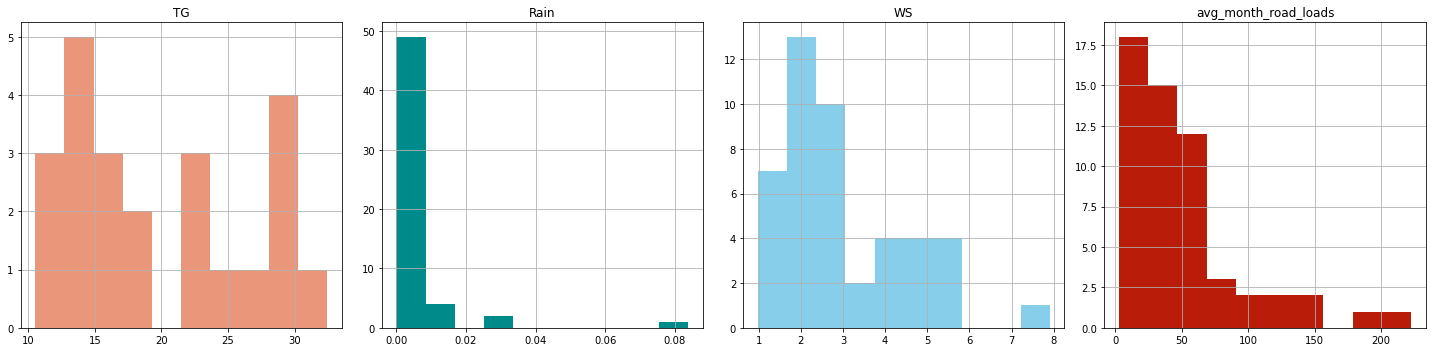

In [9]:
plt.rcParams["figure.figsize"] = [20, 5]
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(1,4)

df_stations_and_traffic_marged.hist('TG',color='#E9967A', ax=axes[0])
df_stations_and_traffic_marged.hist('Rain',color='#008B8B', ax=axes[1])
df_stations_and_traffic_marged.hist('WS',color='#87CEEB', ax=axes[2])
df_stations_and_traffic_marged.hist('avg_month_road_loads',color='#B91D0A', ax=axes[3])

plt.show()


**conclusions:**
* **temperature**- the data covers most of temperature scale
* **rain**- most of the time there is no rain
* **wind velocity**- most of the time the value is between 0 to 3
* **avg_month_road_loads** -daily traffic is between 5,000 to 70,000 most of the days

 

#### Pie charts
Pie charts show the size of items (called wedge) in one data series, proportional to the sum of the items.


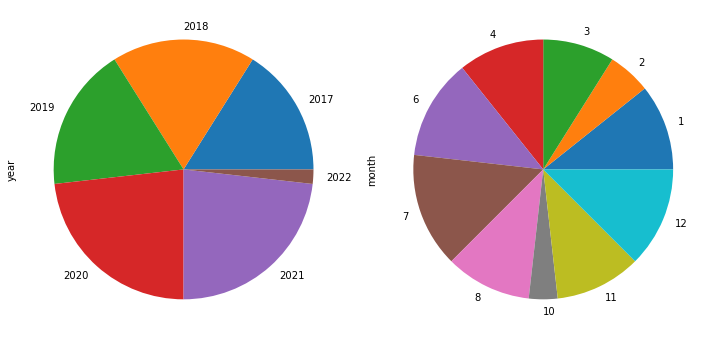

In [10]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(1,2)
df_stations_and_traffic_marged["year"].value_counts().sort_index().plot(kind='pie',ax=axes[0])
df_stations_and_traffic_marged["month"].value_counts().sort_index().plot(kind='pie',ax=axes[1])
plt.show()

**conclusions:**
* **year**- Half of the data refers to the 2 last years- it's an important note because of the incresing of cars number, the global warming And the extreme Climate changes, and of coure the corona virus. All of the above can influence our data.
* **month**- In addition, the data covers most of the months, and distributed equaly between summer and winter

#### Box plot
A box plot displays a summary of a set of months and traffic data- containing the minimum, first quartile, median, and maximum.

C:\Users\gonip\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'traffic by month')

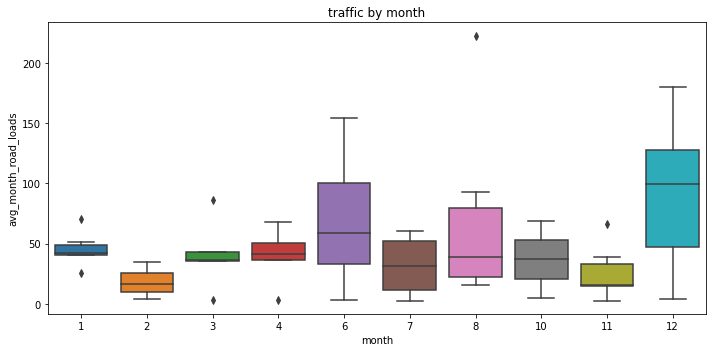

In [11]:
sns.boxplot(df_stations_and_traffic_marged.month, df_stations_and_traffic_marged.avg_month_road_loads)
plt.title("traffic by month")

On the seasons peaks (August & December) there were **exceptional** samples 

violin or box plots

C:\Users\gonip\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'traffic by year')

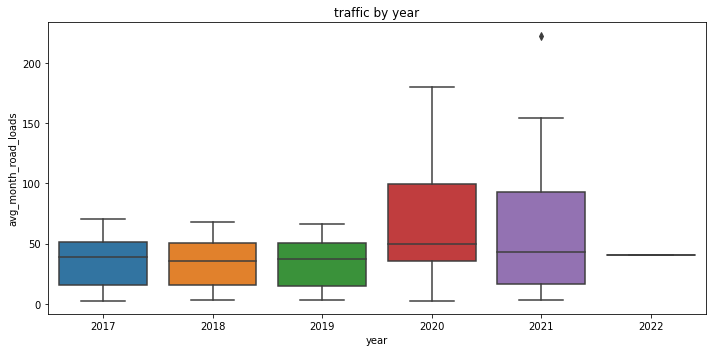

In [12]:
sns.boxplot(df_stations_and_traffic_marged.year, df_stations_and_traffic_marged.avg_month_road_loads)
plt.title("traffic by year")

### correlation

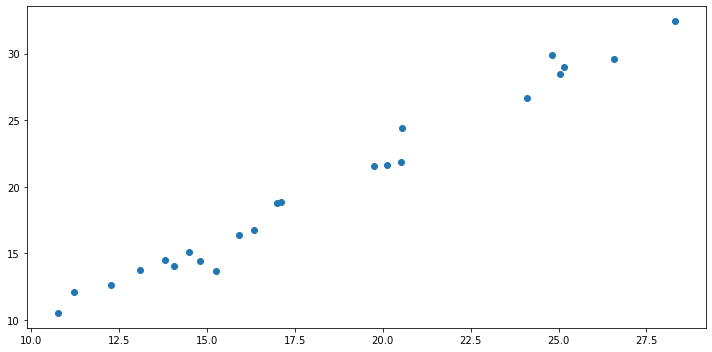

In [13]:
plt.scatter(df_stations_and_traffic_marged.TD, df_stations_and_traffic_marged.TG)

Not surprisingly, the correlation between air temperature and ground temperature creates a line. 
Let's check now the correlation between the weather and traffic data. 



Don't scroll so fast! Do not spoiler.

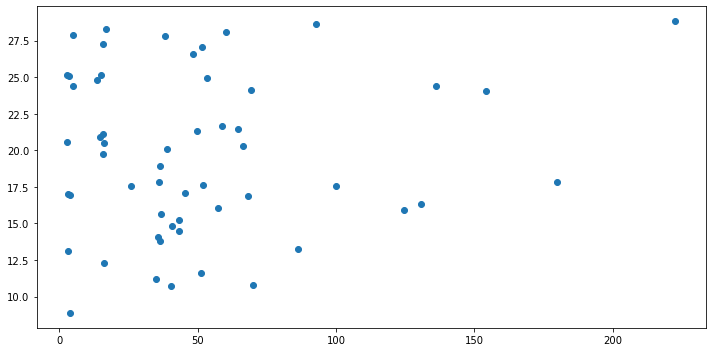

In [14]:
plt.scatter(df_stations_and_traffic_marged.avg_month_road_loads, df_stations_and_traffic_marged.TD)

We can notice that as the temperature gets higher- the traffic gets higher as well.
On the contrary, the lower temperature not effects at all.


In [15]:
df_stations_and_traffic_marged.corr()

,stationId,Rain,WSmax,WDmax,WS,WD,STDwd,TD,RH,TDmax,TDmin,WS1mm,Ws10mm,year,month,TG,avg_month_road_loads
stationId,1.000000,-0.035436,-0.143586,-0.180746,-0.166045,-0.172483,0.157632,0.060274,0.149980,0.032599,0.026506,-0.166494,-0.169937,-0.026339,0.050999,-0.411404,0.357027
Rain,-0.035436,1.000000,0.314481,-0.017783,0.305248,-0.011549,-0.252172,-0.262565,0.404184,-0.265512,-0.261070,0.305549,0.306544,0.063498,-0.164942,-0.270490,-0.064375
WSmax,-0.143586,0.314481,1.000000,0.059898,0.969103,0.022762,-0.596912,-0.056364,-0.256942,-0.058986,-0.053581,0.990069,0.971809,0.096926,-0.157942,-0.107165,-0.254459
WDmax,-0.180746,-0.017783,0.059898,1.000000,0.028629,0.992295,0.119274,0.315120,0.119149,0.316365,0.313617,0.055374,0.029459,0.142526,-0.096056,0.389957,-0.059213
WS,-0.166045,0.305248,0.969103,0.028629,1.000000,-0.001507,-0.715589,-0.078180,-0.199993,-0.081412,-0.074696,0.992956,0.999685,0.098385,-0.159454,-0.241745,-0.166162
WD,-0.172483,-0.011549,0.022762,0.992295,-0.001507,1.000000,0.105780,0.295970,0.133783,0.297251,0.294443,0.021161,-0.000990,0.140386,-0.078474,0.365166,-0.036106
STDwd,0.157632,-0.252172,-0.596912,0.119274,-0.715589,0.105780,1.000000,0.131058,0.111713,0.136291,0.125459,-0.662874,-0.709571,-0.135662,0.045016,0.437496,-0.152189
TD,0.060274,-0.262565,-0.056364,0.315120,-0.078180,0.295970,0.131058,1.000000,-0.159089,0.999964,0.999964,-0.069108,-0.090769,0.331682,0.459305,0.991062,0.096233
RH,0.149980,0.404184,-0.256942,0.119149,-0.199993,0.133783,0.111713,-0.159089,1.000000,-0.149658,-0.149763,-0.233154,-0.205820,0.143847,-0.118450,-0.315267,-0.027060
TDmax,0.032599,-0.265512,-0.058986,0.316365,-0.081412,0.297251,0.136291,0.999964,-0.149658,1.000000,0.999856,-0.072018,-0.093940,0.307989,0.479579,0.991286,0.077481


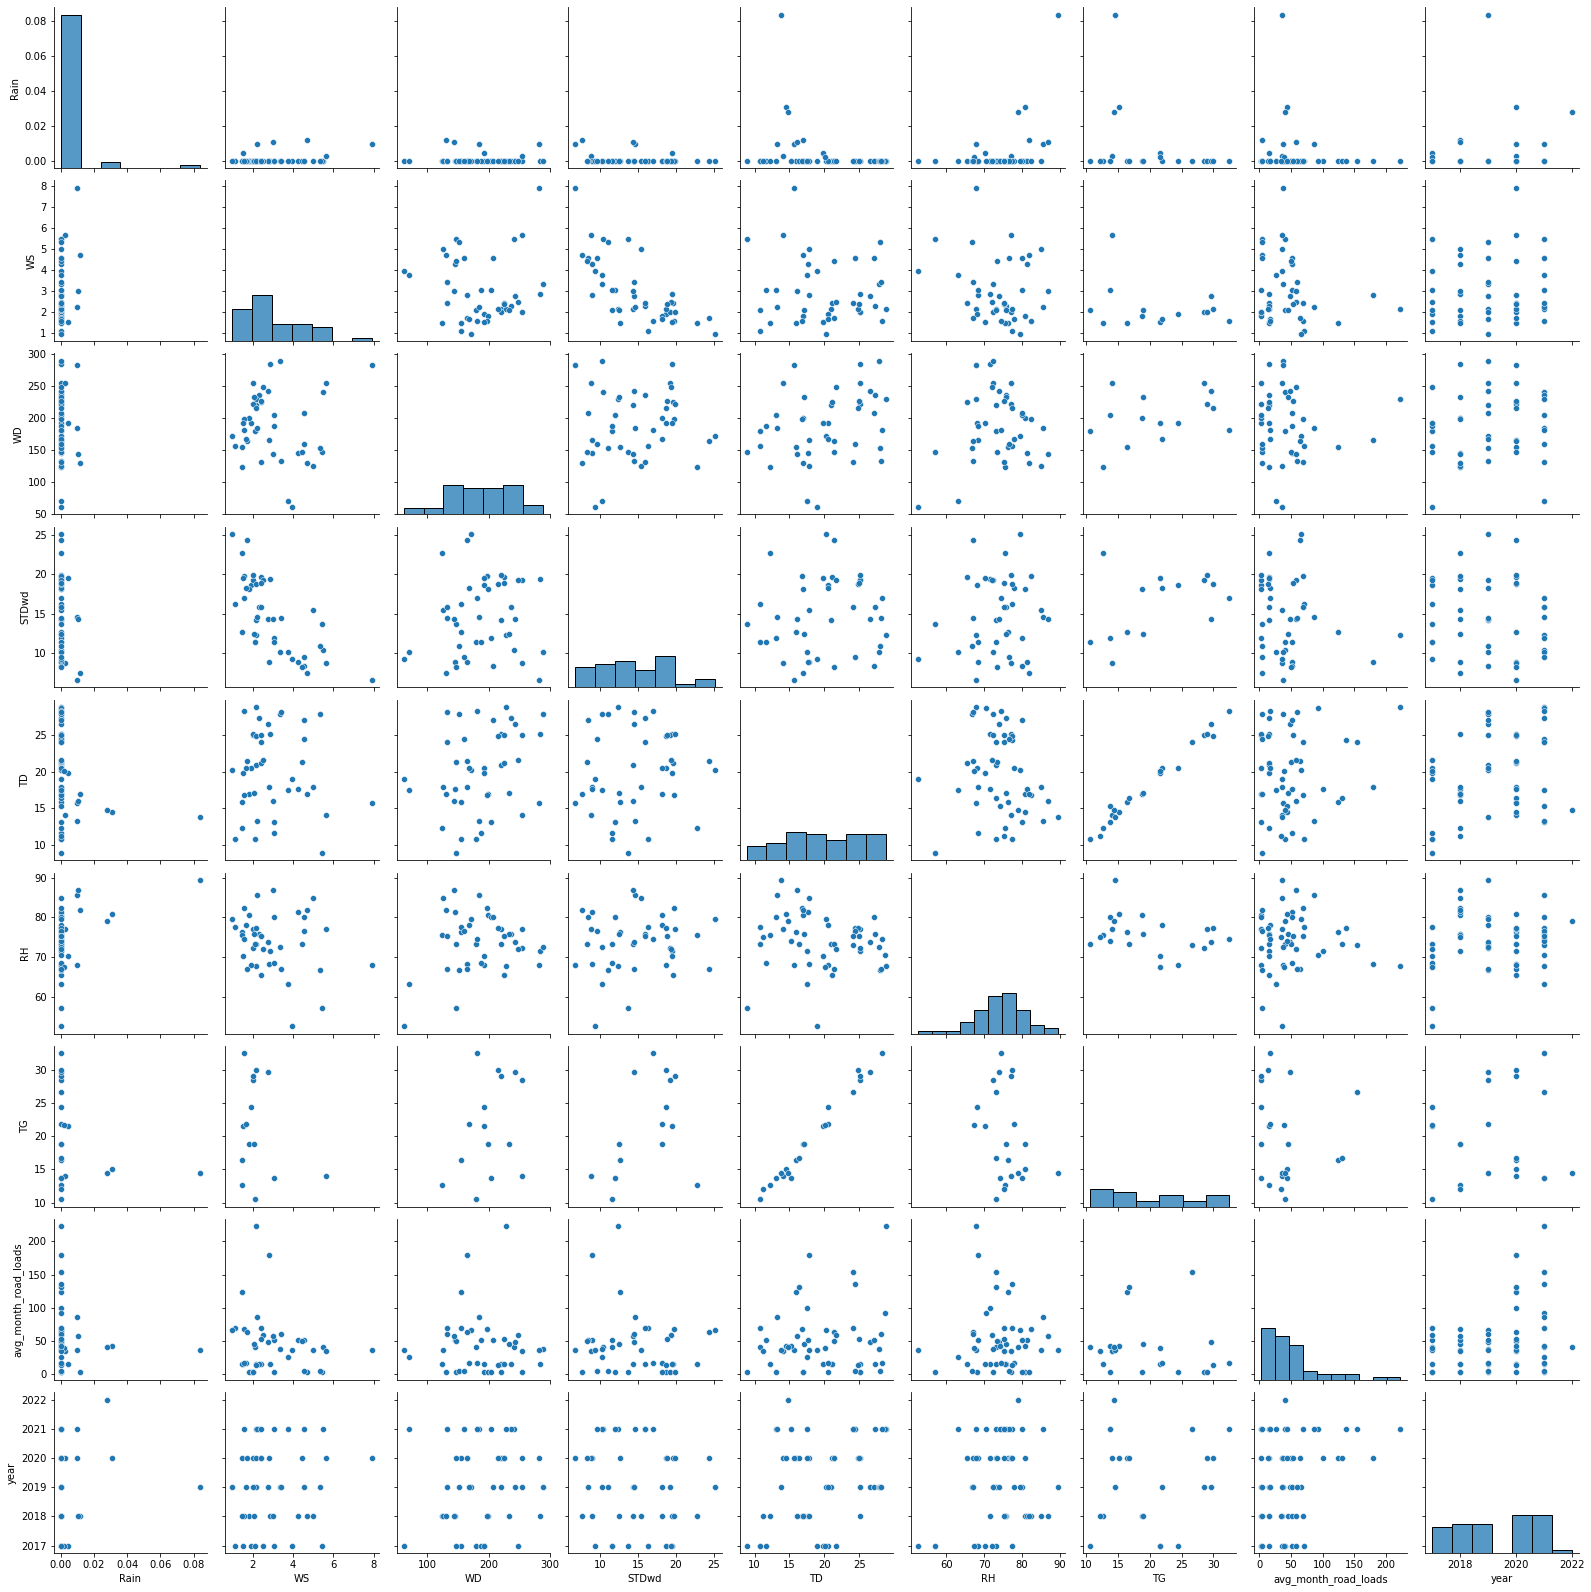

In [16]:
features = ["Rain","WS","WD","STDwd","TD","RH","TG","avg_month_road_loads","year"]

sns.pairplot(df_stations_and_traffic_marged[features])
plt.grid()

we can see that when the X-axis is one of WS, WD, STDwd the values of avg_month_road_loads are not getting above a specific threshold. That means that no matter how long the X-axis will be, the traffic wont rise=> these columns are not making any diffrence.  

#### Heatmaps

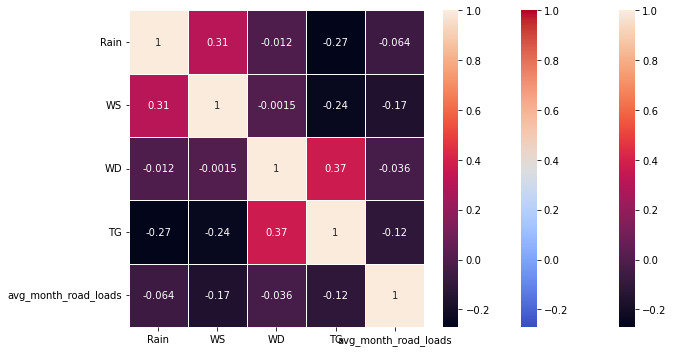

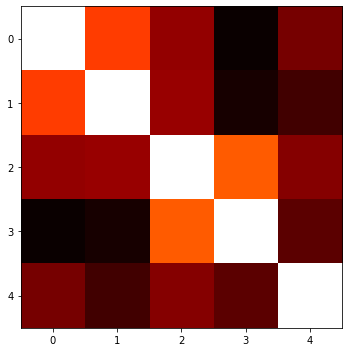

In [17]:
df_heat_map = pd.DataFrame(df_stations_and_traffic_marged, columns = ["Rain","WS","WD","TG","avg_month_road_loads"])
sns.heatmap(df_heat_map.corr(), annot=True)
sns.heatmap(df_heat_map.corr(), cmap='coolwarm') 
ax = sns.heatmap(df_heat_map.corr(), linewidth=1)
plt.show()
plt.imshow(df_heat_map.corr(), cmap='hot')
plt.show()


In [18]:
df_stations_and_traffic_marged.to_csv("df_stations_and_traffic_marged.csv")

### imports 

In [13]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

#and visualization setup
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

from matplotlib import cm

### load DF

In [4]:
df_stations_and_traffic_marged=pd.read_csv('df_stations_and_traffic_marged.csv')
df_stations_and_traffic_marged

,Unnamed: 0,stationId,Rain,WSmax,WDmax,WS,WD,STDwd,TD,RH,TDmax,TDmin,WS1mm,Ws10mm,year,month,TG,avg_month_road_loads
0,0,42,0.000000,7.282857,241.885714,5.475000,240.657143,10.381429,NaN,NaN,NaN,NaN,6.315714,5.661429,2021,8,NaN,40.4
1,1,45,0.000000,5.318182,273.104895,2.844755,283.027972,19.444755,25.118881,71.447552,25.281818,24.948252,3.954545,3.059441,2018,7,NaN,15.0
2,2,45,0.000000,3.578322,223.258741,2.140559,220.286713,14.280420,20.940559,73.153846,21.052448,20.830070,2.841259,2.290909,2019,11,NaN,14.8
3,3,45,0.000000,4.314685,230.650350,2.432867,224.475524,19.653147,21.137762,65.482517,21.288811,20.986713,3.306294,2.625175,2020,6,NaN,15.9
4,4,45,0.000000,3.914493,236.789855,2.306522,235.811594,15.929710,27.294928,75.862319,27.429710,27.148551,3.098551,2.463768,2021,8,NaN,15.8
5,5,54,0.000000,2.188811,152.440559,1.460839,154.594406,12.655944,15.897203,76.398601,16.033566,15.757343,1.896503,1.623077,2020,12,16.401399,124.5
6,6,178,0.000000,3.888112,156.167832,2.830769,164.818182,8.923776,17.841958,68.335664,17.953147,17.738462,3.328671,2.979021,2020,12,NaN,179.8
7,7,178,0.000000,3.142029,227.115942,2.142029,228.768116,12.376087,28.844928,67.804348,28.960145,28.739130,2.646377,2.256522,2021,8,NaN,222.5
8,8,275,0.000000,NaN,NaN,NaN,NaN,NaN,17.562369,71.547038,NaN,NaN,NaN,NaN,2020,12,NaN,99.8
9,9,275,0.000000,NaN,NaN,NaN,NaN,NaN,28.641155,70.429603,NaN,NaN,NaN,NaN,2021,8,NaN,92.8


### clean DF

In [5]:
df_stations_and_traffic_marged.drop(columns = df_stations_and_traffic_marged.columns[0],axis=1,inplace=True)
df_stations_and_traffic_marged.drop(['stationId','year','month'],axis=1,inplace=True)
df_stations_and_traffic_marged.fillna(0,inplace=True)
df_stations_and_traffic_marged = df_stations_and_traffic_marged.div(df_stations_and_traffic_marged.sum(axis=1), axis=0) # normalize data
df_stations_and_traffic_marged_copy=df_stations_and_traffic_marged.copy()
df_stations_and_traffic_marged

,Rain,WSmax,WDmax,WS,WD,STDwd,TD,RH,TDmax,TDmin,WS1mm,Ws10mm,TG,avg_month_road_loads
0,0.000000,0.013050,0.433441,0.009811,0.431239,0.018603,0.000000,0.000000,0.000000,0.000000,0.011317,0.010145,0.000000,0.072394
1,0.000000,0.007067,0.362905,0.003780,0.376091,0.025838,0.033378,0.094940,0.033595,0.033152,0.005255,0.004065,0.000000,0.019932
2,0.000000,0.005777,0.360412,0.003456,0.355614,0.023053,0.033805,0.118094,0.033985,0.033627,0.004587,0.003698,0.000000,0.023892
3,0.000000,0.006824,0.364807,0.003848,0.355040,0.031084,0.033432,0.103570,0.033671,0.033193,0.005229,0.004152,0.000000,0.025148
4,0.000000,0.005809,0.351398,0.003423,0.349947,0.023640,0.040506,0.112580,0.040706,0.040289,0.004598,0.003656,0.000000,0.023447
5,0.000000,0.003698,0.257567,0.002468,0.261206,0.021384,0.026860,0.129085,0.027091,0.026624,0.003204,0.002742,0.027712,0.210358
6,0.000000,0.006032,0.242269,0.004391,0.255688,0.013844,0.027679,0.106012,0.027851,0.027518,0.005164,0.004621,0.000000,0.278930
7,0.000000,0.003674,0.265541,0.002504,0.267473,0.014470,0.033725,0.079276,0.033860,0.033601,0.003094,0.002638,0.000000,0.260144
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.092967,0.378737,0.000000,0.000000,0.000000,0.000000,0.000000,0.528296
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.149273,0.367068,0.000000,0.000000,0.000000,0.000000,0.000000,0.483659


In [6]:
df_stations_and_traffic_marged_copy.drop(['Rain','TG'],axis=1,inplace=True)

In [14]:
df_stations_and_traffic_marged_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   WSmax                 56 non-null     float64
 1   WDmax                 56 non-null     float64
 2   WS                    56 non-null     float64
 3   WD                    56 non-null     float64
 4   STDwd                 56 non-null     float64
 5   TD                    56 non-null     float64
 6   RH                    56 non-null     float64
 7   TDmax                 56 non-null     float64
 8   TDmin                 56 non-null     float64
 9   WS1mm                 56 non-null     float64
 10  Ws10mm                56 non-null     float64
 11  avg_month_road_loads  56 non-null     float64
dtypes: float64(12)
memory usage: 5.4 KB


in this columns we have a lot of 0 values. we delete them to improve machine learning 

## Linear Regression

In [7]:
TRAINING_FEATURES = df_stations_and_traffic_marged_copy.columns[df_stations_and_traffic_marged_copy.columns != 'avg_month_road_loads']
TARGET_FEATURE = 'avg_month_road_loads'

x = df_stations_and_traffic_marged_copy[TRAINING_FEATURES] 
y = df_stations_and_traffic_marged_copy[TARGET_FEATURE] 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)
# y_train=y_train.values.reshape(y_train.size,1)
# y_test=y_test.values.reshape(y_test.size,1)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(42, 11) (42,)
(14, 11) (14,)


In [8]:
lrm = linear_model.LinearRegression()
lrm_model = lrm.fit(x_train, y_train)
lrm_predictions = lrm.predict(x_test)
lrm_predictions

array([ 0.23967536,  0.05677026,  0.05918062,  0.1053637 ,  0.51617757,
        0.04035121,  0.08896917,  0.21928248,  0.13048395,  0.08895147,
       -0.00732635,  0.03216678,  0.02574177,  0.06567982])

In [9]:
print("Score: ", lrm_model.score(x_test, y_test))

Score:  0.9805613268013087


In [10]:
column_labels = x.columns.tolist()
coef = lrm.coef_.squeeze().tolist()

# Zip together & sort list
labels_coef = list(zip(column_labels, coef))
labels_coef.sort(key=lambda x:x[1], reverse=True)

# Verify the result
print(labels_coef)

[('WS', 23.885812970905953), ('TDmin', 22.251206893998546), ('WSmax', 20.441080204728383), ('Ws10mm', 13.354372902956067), ('STDwd', -0.5271182016777642), ('WDmax', -0.7872392623906709), ('TD', -0.7976174756062397), ('RH', -1.062134203383886), ('WD', -1.1971260358220255), ('TDmax', -24.527148327507398), ('WS1mm', -58.41591735502027)]


<AxesSubplot:xlabel='WS', ylabel='avg_month_road_loads'>

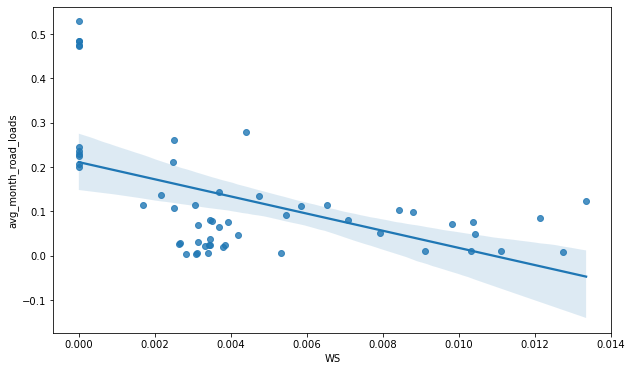

In [11]:
import seaborn as sns
sns.regplot(x='WS', y='avg_month_road_loads', data=df_stations_and_traffic_marged_copy)

<AxesSubplot:xlabel='TDmin', ylabel='avg_month_road_loads'>

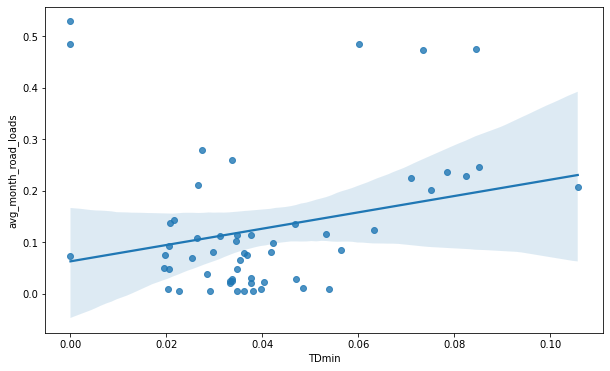

In [12]:
sns.regplot(x='TDmin', y='avg_month_road_loads', data=df_stations_and_traffic_marged_copy)